In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import numba as nb

from utils import (
    combine_uncertaintes,
    plot_pixels,
    confidence_interval,
    wald_uncertainty,
)

# ignore deprecation warnings from numba for now
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter("ignore", category=NumbaDeprecationWarning)
warnings.simplefilter("ignore", category=NumbaPendingDeprecationWarning)

/Users/stefan/mambaforge/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/stefan/Documents/projects/Challenges/computing/utils.py:69: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def wald_uncertainty(numer, denom):


**Goal:** improve the world's best estimate of the area of the Mandelbrot set.

The [Mandelbrot set](https://en.wikipedia.org/wiki/Mandelbrot_set) is a set of [complex numbers](https://en.wikipedia.org/wiki/Complex_number) $c$ for which

$$z_{i + 1} = |z_i|^2 + c \mbox{ with } z_0 = 0$$

does not diverge to infinity. That is, the set $c$ for which $|z_i| \to \infty$ as $i \to \infty$. Sequences $z_i$ that cycle or converge to any finite point are considered in the set; anything else is outside the set.

The following function identifies whether a _point_ $c = x + y i$ is in the Mandelbrot set or not ($x$ and $y$ are real numbers and $i = \sqrt{-1}$). It uses 32-bit (single precision) floating point to approximate real numbers (`np.complex64` is made of two `np.float32`). The algorithm tracks $z_i$ for two consecutive $i$, named "tortoise" and "hare" because [the hare is ahead of the tortoise](https://en.wikipedia.org/wiki/The_Tortoise_and_the_Hare) by a factor of 2. This is [Floyd's algorithm](https://en.wikipedia.org/wiki/Cycle_detection#Floyd%27s_tortoise_and_hare) for detecting cycles in a sequence (including the "cycle" of converging to a point).

In [2]:
@nb.jit
def is_in_mandelbrot(x, y):
    """Toirtoise and Hare approach to check if point (x,y) is in Mandelbrot set."""
    c = np.complex64(x) + np.complex64(y) * np.complex64(1j)
    z_hare = z_tortoise = np.complex64(0)  # tortoise and hare start at same point
    while True:
        z_hare = z_hare * z_hare + c
        z_hare = (
            z_hare * z_hare + c
        )  # hare does one step more to get ahead of the tortoise
        z_tortoise = z_tortoise * z_tortoise + c  # tortoise is one step behind
        if z_hare == z_tortoise:
            return True  # orbiting or converging to zero
        if z_hare.real**2 + z_hare.imag**2 > 4:
            return False  # diverging to infinity

There's a mathematical theorem ([Knill (2023)](https://doi.org/10.48550/arXiv.2305.17848), section 4.7) that proves that the Mandelbrot set is entirely contained within $x \in (-2, 1)$, $y \in (-\frac{3}{2}, \frac{3}{2})$.

If $|z_i|^2 > 4$, then the $z_{i+1}$ with the smallest magnitude in that box is at $c = -2 + 0 i$, and that $z_{i+1} > 2$, which also has magnitude greater than $4$, so if a sequence ever exceeds $|z_i|^2 > 4$, then it diverges to infinity.

Let's take a look at it.

In [3]:
@nb.jit(parallel=True)
def draw_mandelbrot(num_x, num_y):
    """Generate Mandelbrot set inside Knill limits"""
    # Knill limits
    xmin, xmax = -2, 1
    ymin, ymax = -3 / 2, 3 / 2

    # Generate empty pixel array with pixel size (dx,dy)
    pixels = np.empty((num_x, num_y), np.int32)
    dx = (xmax - xmin) / num_x
    dy = (ymax - ymin) / num_y

    # Fill pixels if pixel is in Mandelbrot set
    for i in nb.prange(num_x):
        for j in nb.prange(num_y):
            x = xmin + i * dx
            y = ymin + j * dy
            pixels[j, i] = is_in_mandelbrot(x, y)  # function from above

    return pixels

In [4]:
pixels = draw_mandelbrot(1000, 1000)

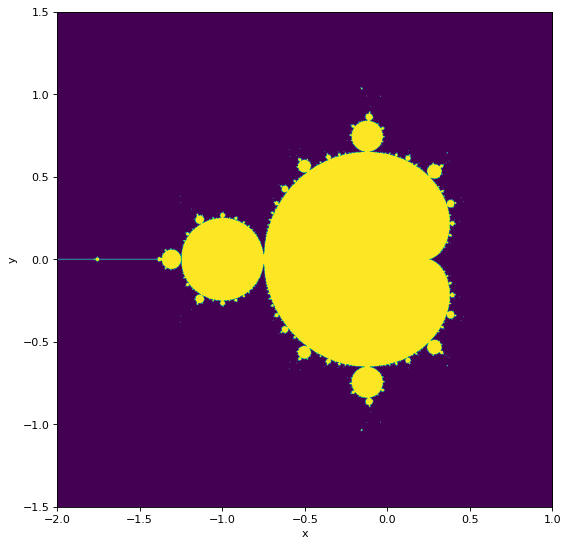

In [5]:
fig, _, _ = plot_pixels(pixels, dpi=80)

The exact area of the Mandelbrot set is not known, mathematically. There is an expression,

$$\mbox{area of Mandelbrot set} = \pi \left( 1 - \sum_{n=1}^\infty n \, {b_n}^2 \right)$$

in which the terms $b_n$ can be determined recursively, but it converges very slowly: $10^{118}$ terms are needed to get the first 2 digits, and $10^{1181}$ terms are needed to get 3 digits ([Ewing & Schober (1992)](https://doi.org/10.1007/BF01385497)). The best estimates of the Mandelbrot set's area come from sampling techniques. The most recent publication is [Bittner, Cheong, Gates, & Nguyen (2012)](https://doi.org/10.2140/involve.2017.10.555) and the most recent unpublished estimate is [Förstemann (2017)](https://www.foerstemann.name/labor.html) using two Radeon HD 5970 GPUs. The most precise, rigorous bounds to date are

$$1.50640 < \mbox{area of Mandelbrot set} < 1.53121\mbox{.}$$

(If you're interested in this sort of thing, Robert Munafo wrote a [rabbit warren of hyperlinked pages](http://www.mrob.com/pub/muency/areaofthemandelbrotset.html) about all of the techniques in 2003, from a [Usenet thread (alt.fractals)](https://ics.uci.edu/~eppstein/junkyard/mand-area.html) that started exactly 5 days after the [first release of Python (alt.sources)](https://www.tuhs.org/Usenet/alt.sources/1991-February/001749.html). Weird coincidence, huh?)

The goal of this project is to estimate the area of the Mandelbrot set by sampling, _maybe improving upon the world's best estimate._

In [6]:
@nb.jit
def count_mandelbrot(rng, num_samples, xmin, width, ymin, height):
    """Draw num_samples random numbers uniformly between (xmin, xmin+width)
    and (ymin, ymin+height).
    Raise `out` by one if the number is part of the Mandelbrot set.
    """
    out = np.int32(0)
    for x_norm, y_norm in rng.random((num_samples, 2), np.float32):
        x = xmin + (x_norm * width)
        y = ymin + (y_norm * height)
        out += is_in_mandelbrot(x, y)
    return out

In [7]:
# Knill limits
xmin, xmax = -2, 1
ymin, ymax = -3 / 2, 3 / 2

rng = np.random.default_rng()  # can be forked to run multiple rngs in parallel

denominator = 100000  # how many random numbers to draw


numerator = count_mandelbrot(rng, denominator, xmin, xmax - xmin, ymin, ymax - ymin)

# ratio of numbers inside Mandelbrot set times sampling area
area = (numerator / denominator) * (xmax - xmin) * (ymax - ymin)
area

1.5129900000000003

Just like an experimental measurement, sampling introduces uncertainty. To the (very high) degree that our generated random numbers are independent, sampling an area and asking which points are in the Mandelbrot set are [Bernoulli trials](https://en.wikipedia.org/wiki/Bernoulli_trial), and we can use the (conservative but exact) [Clopper-Pearson interval](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Clopper%E2%80%93Pearson_interval) to quantify the uncertainty.

In the following, there is a 95% probability that the true Mandelbrot area is between `low` and `high`.
The implementation can be found in `utils.py`.

In [8]:
confidence_interval(0.05, numerator, denominator, (xmax - xmin) * (ymax - ymin))

(1.492171557083198, 1.5339818413202444)

We can reduce this interval by increasing `num_samples`, but look at the plot: there are regions of fine detail and regions that are almost entirely inside or outside of the set. Samples in different geographic regions make wildly different contributions to the uncertainty in the final result.

In [9]:
region1 = {"xmin": -1.5, "ymin": 0.5, "width": 0.5, "height": 0.5}
region2 = {"xmin": -0.4, "ymin": 0.5, "width": 0.5, "height": 0.5}
region3 = {"xmin": -0.4, "ymin": -0.25, "width": 0.5, "height": 0.5}

for region in [region1, region2, region3]:
    denominator = 10000
    numerator = count_mandelbrot(rng, denominator, region["xmin"], region["width"], region["ymin"], region["height"])

    low, high = confidence_interval(0.05, numerator, denominator, region["width"] * region["height"])

    print(f"{numerator:5d}/{denominator}  -->  low: {low:8.3g}, high: {high:8.3g}  -->  uncertainty: {high - low:8.3g}")

    0/10000  -->  low:        0, high: 9.22e-05  -->  uncertainty: 9.22e-05
 3992/10000  -->  low:   0.0974, high:    0.102  -->  uncertainty:  0.00482
10000/10000  -->  low:     0.25, high:     0.25  -->  uncertainty: 9.22e-05


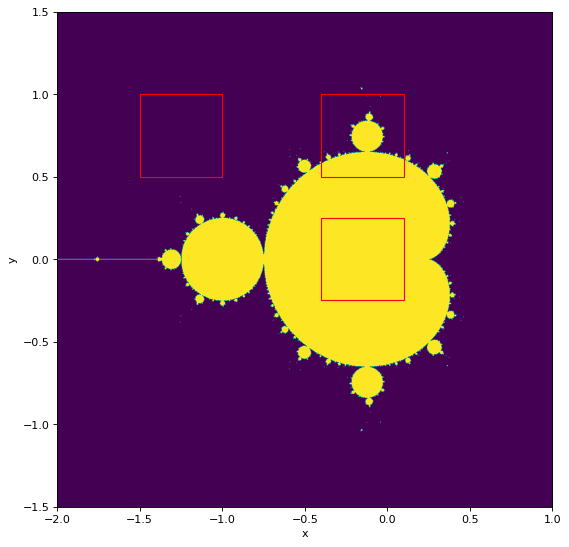

In [10]:
fig, ax, _ = plot_pixels(pixels, dpi=80)

ax.add_patch(matplotlib.patches.Rectangle((-1.5, 0.5), 0.5, 0.5, edgecolor="red", facecolor="none"))
ax.add_patch(matplotlib.patches.Rectangle((-0.4, 0.5), 0.5, 0.5, edgecolor="red", facecolor="none"))
ax.add_patch(matplotlib.patches.Rectangle((-0.4, -0.25), 0.5, 0.5, edgecolor="red", facecolor="none"))

None

To get more precision in the final result per time spent calculating, we want to sample the rough (fractal!) edge of the Mandelbrot set more than the regions that are mostly inside (yellow) or mostly outside (dark blue) the set. We can

1. vary the number of samples in some continuous way, which is hard to do for a shape as complicated as the Mandelbrot set,
2. subdivide the plane into smaller tiles near areas of detail use the same number of random samples in each tile, or
3. subdivide the plane into equal-sized tiles and use different numbers of samples in each tile. The processor for each tile can keep working until it reaches some uncertainty goal.

We'll use method 3 because it's easiest to implement: each tile can run independently of the others.

Start by creating numerator and denominator arrays, with each array element corresponding to a tile.

In [11]:
NUM_TILES_1D = 100

numer = np.zeros((NUM_TILES_1D, NUM_TILES_1D), dtype=np.int64)
denom = np.zeros((NUM_TILES_1D, NUM_TILES_1D), dtype=np.int64)

The width and height of each tile is the same:

In [12]:
width = 3 / NUM_TILES_1D
height = 3 / NUM_TILES_1D

But each tile has a different `xmin` and `ymin`.

In [13]:
@nb.jit
def xmin(j):
    return -2 + width * j

@nb.jit
def ymin(i):
    return -3/2 + height * i

Now we just iterate over the tiles and do what we did before: uniformly sample points within each square tile.

In [14]:
@nb.jit
def compute_sequentially(rng, numer, denom):
    """Sample 100 points in each tile."""
    for i in range(NUM_TILES_1D):
        for j in range(NUM_TILES_1D):
            denom[i, j] = 100
            numer[i, j] = count_mandelbrot(rng, denom[i, j], xmin(j), width, ymin(i), height)

compute_sequentially(rng, numer, denom)

A plot of the result now can have `numer / denom` values between 0 and 1 (unlike the original plot).

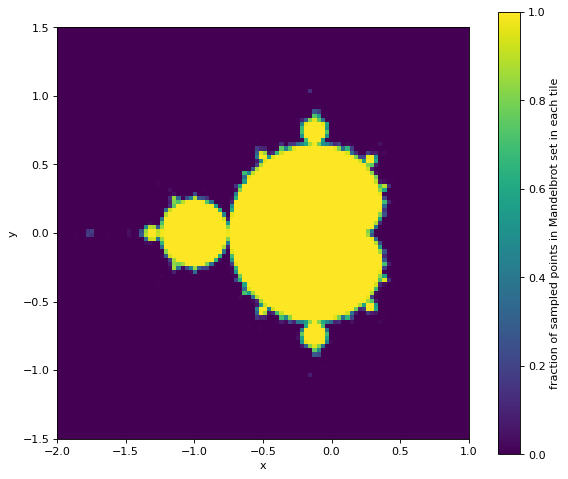

In [15]:
fig, ax, p = plot_pixels(numer / denom, dpi=80)
fig.colorbar(p, ax=ax, shrink=0.8, label="fraction of sampled points in Mandelbrot set in each tile")

None

As an aside, the calculation of Mandelbrot area in each tile is independent, but if you're going to sample them in parallel, you need to have a team of non-overlapping random number generators.

In [16]:
rngs = rng.spawn(NUM_TILES_1D * NUM_TILES_1D)

In [17]:
@nb.jit(parallel=True)
def compute_parallel(rngs, numer, denom):
    """Sample all tiles in parallel with NUM_TILES_1D**2 rngs."""
    for i in nb.prange(NUM_TILES_1D):
        for j in nb.prange(NUM_TILES_1D):
            rng = rngs[NUM_TILES_1D * i + j]  # get rng for this tile

            denom[i, j] = 100
            numer[i, j] = count_mandelbrot(
                rng, denom[i, j], xmin(j), width, ymin(i), height
            )

numer = np.zeros((NUM_TILES_1D, NUM_TILES_1D), dtype=np.int64)
denom = np.zeros((NUM_TILES_1D, NUM_TILES_1D), dtype=np.int64)

compute_parallel(rngs, numer, denom)

The way we sampled it above, every tile has the same denominator.

In [18]:
(denom == 100).all()

True

But the tiles that are nearly 0% or nearly 100% have less uncertainty than the tiles along the rough (fractal) edge.

In [19]:
CONFIDENCE_LEVEL = 0.05

confidence_interval_low, confidence_interval_high = confidence_interval(
    CONFIDENCE_LEVEL / 2, numer, denom, width * height
)

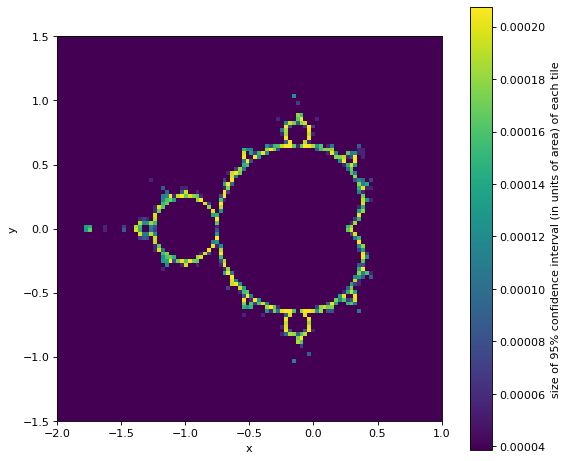

In [20]:
fig, ax, p = plot_pixels(confidence_interval_high - confidence_interval_low, dpi=80)
fig.colorbar(p, ax=ax, shrink=0.8, label="size of 95% confidence interval (in units of area) of each tile")

None

Instead of a constant denominator, let's keep adding points until the uncertainty in a tile gets below a target threshold.

Since this uncertainty is only used to decide whether to add more points, we can use an approximation (biased [Wald interval](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Problems_with_using_a_normal_approximation_or_%22Wald_interval%22)).
The implementation is found in `utils.py`.

Even with this simplified estimator of uncertainty, we'll want to compute batches so that we spend more time calculating Mandelbrot points than asking, "Are we there yet?"

In [21]:
SAMPLES_IN_BATCH = 100

@nb.jit(parallel=True)
def compute_until(rngs, numer, denom, uncert, uncert_target):
    """Compute area of each tile until uncert_target is reached.
    The uncertainty is calculate with the Wald approximation in each tile.
    """
    for i in nb.prange(NUM_TILES_1D):
        for j in nb.prange(NUM_TILES_1D):
            rng = rngs[NUM_TILES_1D * i + j]

            uncert[i, j] = np.inf

            # Sample SAMPLES_IN_BATCH more points until uncert_target is reached
            while uncert[i, j] > uncert_target:
                denom[i, j] += SAMPLES_IN_BATCH
                numer[i, j] += count_mandelbrot(
                    rng, SAMPLES_IN_BATCH, xmin(j), width, ymin(i), height
                )

                uncert[i, j] = (
                    wald_uncertainty(numer[i, j], denom[i, j]) * width * height
                )

numer = np.zeros((NUM_TILES_1D, NUM_TILES_1D), dtype=np.int64)
denom = np.zeros((NUM_TILES_1D, NUM_TILES_1D), dtype=np.int64)
uncert = np.zeros((NUM_TILES_1D, NUM_TILES_1D), dtype=np.float64)

compute_until(rngs, numer, denom, uncert, 1e-5)

Now we've ensured that all of the tile uncertainties are at the scale of `uncert_target` or below (roughly, since we're using an approximation).

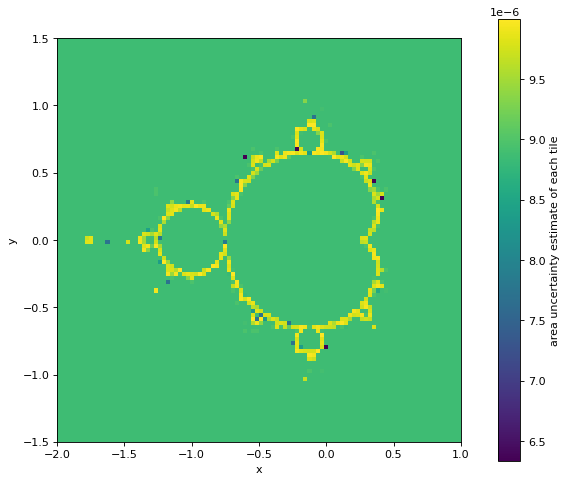

In [22]:
fig, ax, p = plot_pixels(uncert, dpi=80)
fig.colorbar(p, ax=ax, shrink=0.8, label="area uncertainty estimate of each tile")

None

The denominators needed to do this vary considerably from one tile to the next.

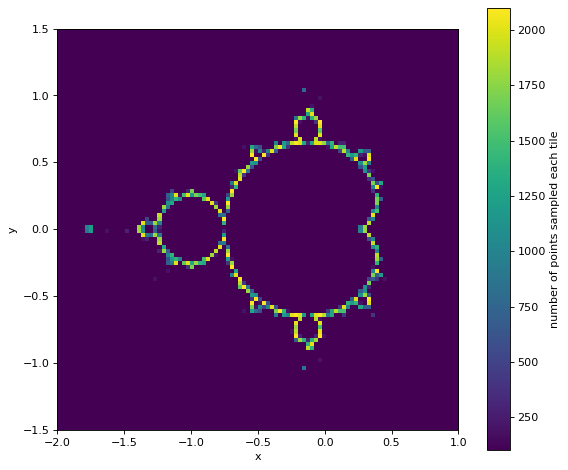

In [23]:
fig, ax, p = plot_pixels(denom, dpi=80)
fig.colorbar(p, ax=ax, shrink=0.8, label="number of points sampled each tile")

None

The final result can be derived from the individual numerators and denominators.

In [24]:
final_value = (np.sum((numer / denom)) * width * height).item()
final_value

1.5066299753205772

We can use full, high-precision confidence intervals in the final result.
The implementation of this can be seen in `utils.py`.

In [25]:
CONFIDENCE_LEVEL = 0.05

confidence_interval_low, confidence_interval_high = confidence_interval(
    CONFIDENCE_LEVEL, numer, denom, width * height
)

final_uncertainty = combine_uncertaintes(
    confidence_interval_low, confidence_interval_high, denom
)
final_uncertainty

Your task is to implement this on GPUs and scale it to many computers.

Your result, at the end of this exercise, may be the world's most precise estimate of a fundamental mathematical quantity.